In [2]:
!pip install torchinfo
import torch
from torchvision import datasets
from torchvision import transforms
from torchinfo import summary
import matplotlib.pyplot as plt


In [3]:
tensor_transform = transforms.ToTensor()
dataset = datasets.FashionMNIST(root = "./data", train = True, download = True, transform = tensor_transform)
loader = torch.utils.data.DataLoader(dataset = dataset, batch_size = 32, shuffle = True)

testset = datasets.FashionMNIST(root = "./data", train = False, download = True, transform = tensor_transform)
testloader = torch.utils.data.DataLoader(dataset = testset, batch_size = 1000, shuffle = False)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [4]:
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True


## MLP

In [5]:
class AESimple(torch.nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(28*28, latent_dim),
            torch.nn.ReLU()
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(self.latent_dim, 28*28),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        reshaped = torch.reshape(decoded, (-1,1,28,28))
        return reshaped


In [6]:
def train_eval(epochs, lr, model, loader, testloader):
    pelosses = []
    pelosses_test = []

    model = model.to(device)
    loss_function = torch.nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr) #, weight_decay = 1e-8)

    for epoch in range(epochs):    
        peloss = 0.0
        for (image, _) in loader:
            image = image.to(device)
            reconstructed = model(image)  
            loss = loss_function(reconstructed, image)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()        
            peloss += loss.item()
        peloss /= len(loader)
        pelosses.append(peloss)
    
        pelosstest = 0.0
        with torch.no_grad():
            for (image,_) in testloader:
                image = image.to(device)
                reconstructed = model(image)  
                pelosstest += loss_function(reconstructed, image).item()
            pelosstest /= len(testloader)
            pelosses_test.append(pelosstest)
        print("Epoch %i: %6.4f  %6.4f"%(epoch,peloss,pelosstest))
    return pelosses, pelosses_test

In [7]:
def plot_loss(pelosses, pelosses_test):
    plt.style.use('fivethirtyeight')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    epochs = len(pelosses)
    plt.semilogy(torch.arange(epochs)+1, pelosses, 'b-')
    plt.semilogy(torch.arange(epochs)+1, pelosses_test, 'r-')    

Epoch 0: 0.0223  0.0122
Epoch 1: 0.0104  0.0094
Epoch 2: 0.0086  0.0082


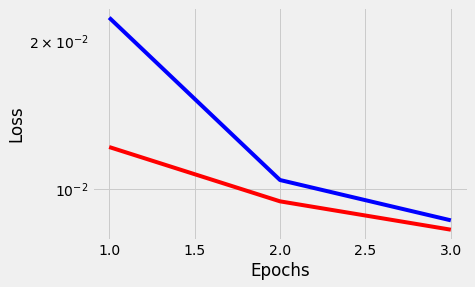

In [8]:
nepochs = 3
model = AESimple(128).to(device)
summary(model, (1,28,28))
pelosses, pelosses_test = train_eval(nepochs, 0.001, model, loader, testloader)
plot_loss(pelosses, pelosses_test)

In [9]:
def reconstruct(img, model):
    img = model(img)
    return img

def plot_img(img, title):
    plt.title(title)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")

def plot_samples(dataset, models):
    n = 10
    m = len(models)
    indices = torch.randint(len(dataset), size=(n,))
    cols, rows = n, m+1
    figure = plt.figure(figsize=(18, (m+1)*2))
    for i in range(n):
        idx = indices[i].item()
        img, label = dataset[idx]
        figure.add_subplot(rows, cols, i+1)
        plot_img(img.numpy(), "")
    
        for j in range(m):
            figure.add_subplot(rows, cols, (j+1)*n+i+1)
            img, label = dataset[idx]
            img = reconstruct(img, models[j].to("cpu")).detach().numpy()
            plot_img(img, "")
    
    plt.show()

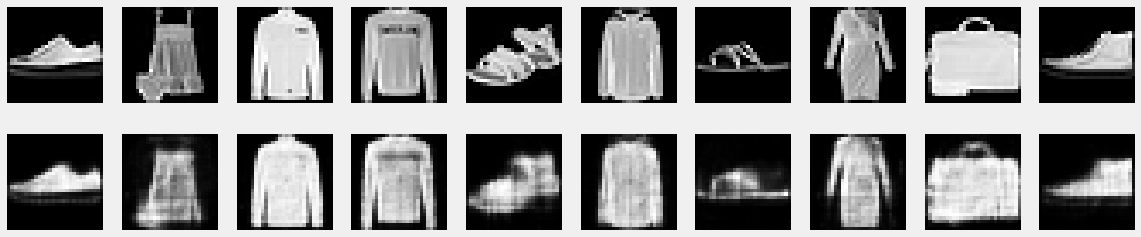

In [10]:
plot_samples(testset, [model])

In [11]:
def interpolate(img1, img2, model, d):
    n = 20
    lrow = int(n/2)
    
    model = model.to("cpu")

    img1 = img1.view(-1,1,28*28)
    z1 = model.encoder(img1)
    
    z1 = z1.view(-1,d)
    rec1 = model.decoder(z1)
    img2 = img2.view(-1,28*28)
    z2 = model.encoder(img2)
    z2 = z2.view(-1,d)
    rec2 = model.decoder(z2)
    
    imgs = [img1.detach().numpy(), rec1.detach().numpy()]
    for i in range(n-4):
        z = z1 + (z2-z1)*i/(n-4)
        img_dist = model.decoder(z).detach().numpy()
        imgs.append(img_dist)

    imgs.append(rec2.detach().numpy())
    imgs.append(img2.detach().numpy())

    plt.figure(figsize=(18, 4))
    for i in range(lrow):
        ax = plt.subplot(2, lrow, i + 1)
        plot_img(imgs[i].reshape(28,28), "")
    
    for i in range(lrow):
        ax = plt.subplot(2, lrow, i + 1 + lrow)
        plot_img(imgs[lrow+i].reshape(28,28), "")

plt.show()

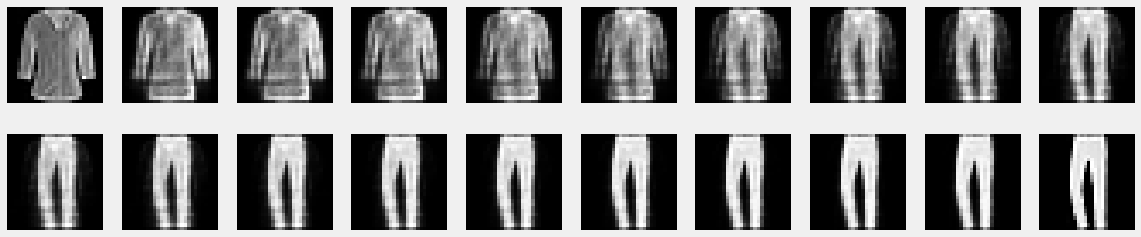

In [12]:
interpolate(testset[4][0], testset[2][0], model, 128)

In [13]:
def noise_added(inputs, model, sigma=0.2):
    n = 10
    m = len(inputs)
    to_plot = {}
    model = model.to("cpu")
    for j in range(m):
        img = inputs[j]
        z = model.encoder(img)
        rec = model.decoder(z)    
        imgs = [img.detach().numpy(), rec.detach().numpy()]
        for i in range(n-2):
            noise = sigma*torch.randn((model.latent_dim,))
            img_dist = model.decoder(z+noise).detach().numpy()
            imgs.append(img_dist)        
        to_plot[j] = imgs
        
    plt.figure(figsize=(20, m*2))
    ax = plt.subplot(m, n, 1)
    for j in range(m):
        for i in range(n):
            ax = plt.subplot(m, n, j*n+i+1)
            plot_img(to_plot[j][i].reshape(28,28), "")
        
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


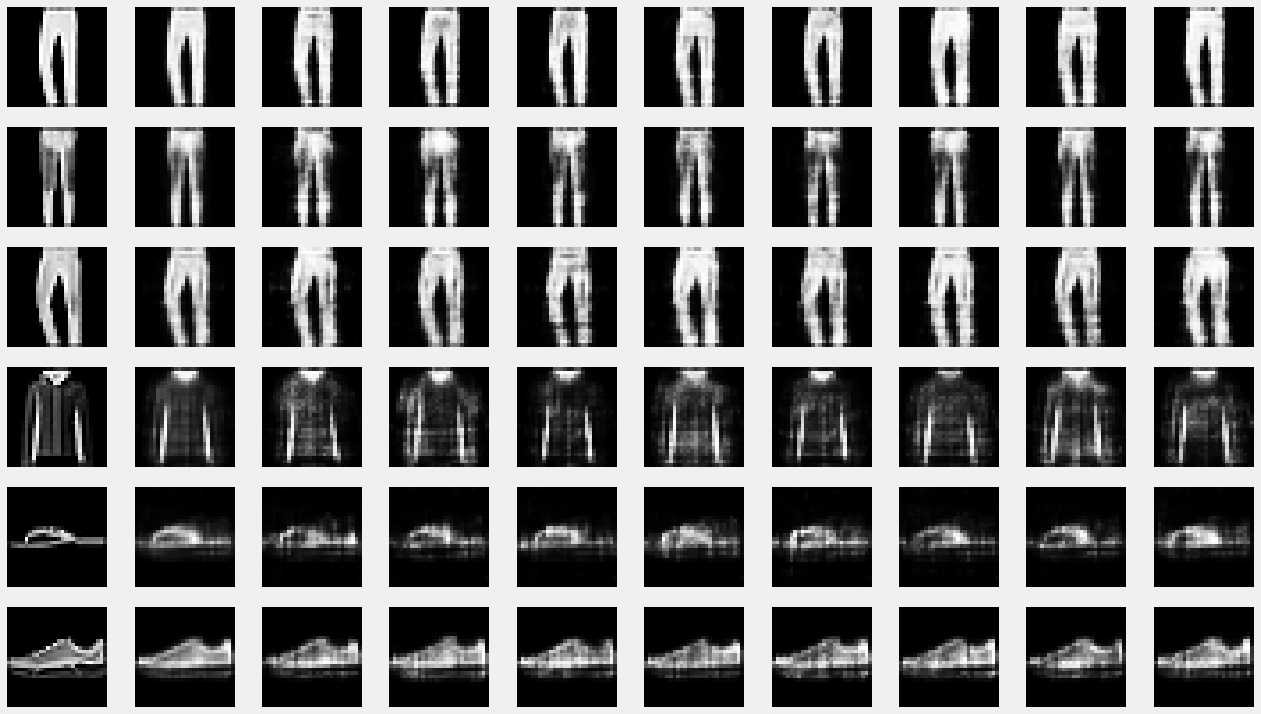

In [14]:
noise_added([testset[i][0] for i in [2,3,5,6,8,9]], model, sigma=0.5)

In [15]:
def generated(model, ld=None):
    cols = 10
    rows = 6
    model = model.to("cpu")
    plt.figure(figsize=(20, rows*2))
    ax = plt.subplot(rows, cols, 1)
    d = model.latent_dim if hasattr(model,"latent_dim") else ld
    for j in range(rows):
        for i in range(cols):
            z = torch.randn((d,)).view(-1,d)
            rec = model.decoder(z).detach().numpy()        
            ax = plt.subplot(rows, cols, j*cols+i+1)
            plot_img(rec.reshape(28,28), "")
        
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


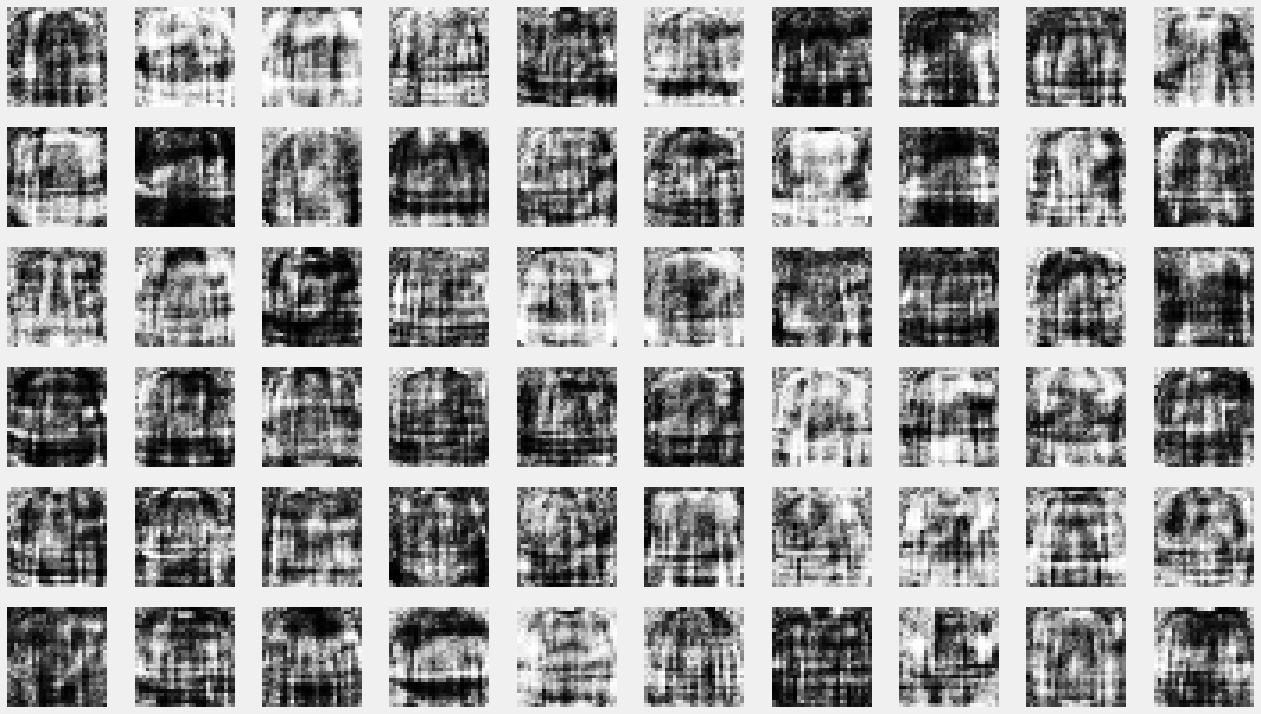

In [16]:
generated(model)

## CNN

In [17]:
class AECNN1(torch.nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        # YOUR CODE
        self.d = latent_dim // 4

        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=64, out_channels=self.d, kernel_size=3, stride=2),
            torch.nn.Flatten(),
        )
        
        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(in_channels=self.d, out_channels=64, kernel_size=3, stride=2),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=5, stride=1),
            torch.nn.Sigmoid(),
        )
        
        # YOUR CODE
  
    def forward(self, x):
        # YOUR CODE
        
        x = x.view(-1,1,28,28)
        z = self.encoder(x)
        z = z.view(-1,self.d,2,2)
        reconstructed = self.decoder(z)
        
        return reconstructed

        # YOUR CODE


In [18]:
epochs = 3
lr = 0.001
model = AECNN1(128).to(device)
pelosses2, pelosses_test2 = train_eval(epochs, lr, model, loader, testloader)

summary(model,(1,28,28))

Epoch 0: 0.0213  0.0125
Epoch 1: 0.0106  0.0095
Epoch 2: 0.0087  0.0081


Layer (type:depth-idx)                   Output Shape              Param #
AECNN1                                   --                        --
├─Sequential: 1-1                        [1, 128]                  --
│    └─Conv2d: 2-1                       [1, 16, 24, 24]           416
│    └─ReLU: 2-2                         [1, 16, 24, 24]           --
│    └─Conv2d: 2-3                       [1, 32, 11, 11]           8,224
│    └─ReLU: 2-4                         [1, 32, 11, 11]           --
│    └─Conv2d: 2-5                       [1, 64, 5, 5]             18,496
│    └─ReLU: 2-6                         [1, 64, 5, 5]             --
│    └─Conv2d: 2-7                       [1, 32, 2, 2]             18,464
│    └─Flatten: 2-8                      [1, 128]                  --
├─Sequential: 1-2                        [1, 1, 28, 28]            --
│    └─ConvTranspose2d: 2-9              [1, 64, 5, 5]             18,496
│    └─ReLU: 2-10                        [1, 64, 5, 5]             --

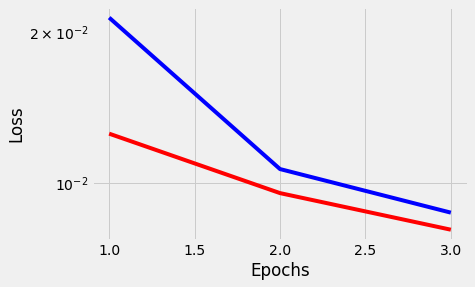

In [19]:
plot_loss(pelosses2, pelosses_test2)

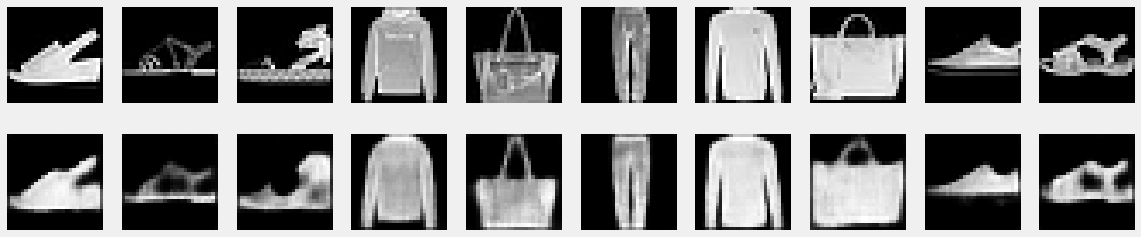

In [20]:
plot_samples(testset, [model])

In [21]:
def generated4cnn(model, ld=None):
    cols = 10
    rows = 6
    model = model.to("cpu")
    plt.figure(figsize=(20, rows*2))
    ax = plt.subplot(rows, cols, 1)
    d = model.latent_dim if hasattr(model,"latent_dim") else ld
    print(d)
    for j in range(rows):
        for i in range(cols):
            z = torch.randn((d,)).view(-1,d//4,2,2)
            rec = model.decoder(z).detach().numpy()      
            ax = plt.subplot(rows, cols, j*cols+i+1)

            plot_img(rec.reshape(28,28), "")
        
    plt.show()

128


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


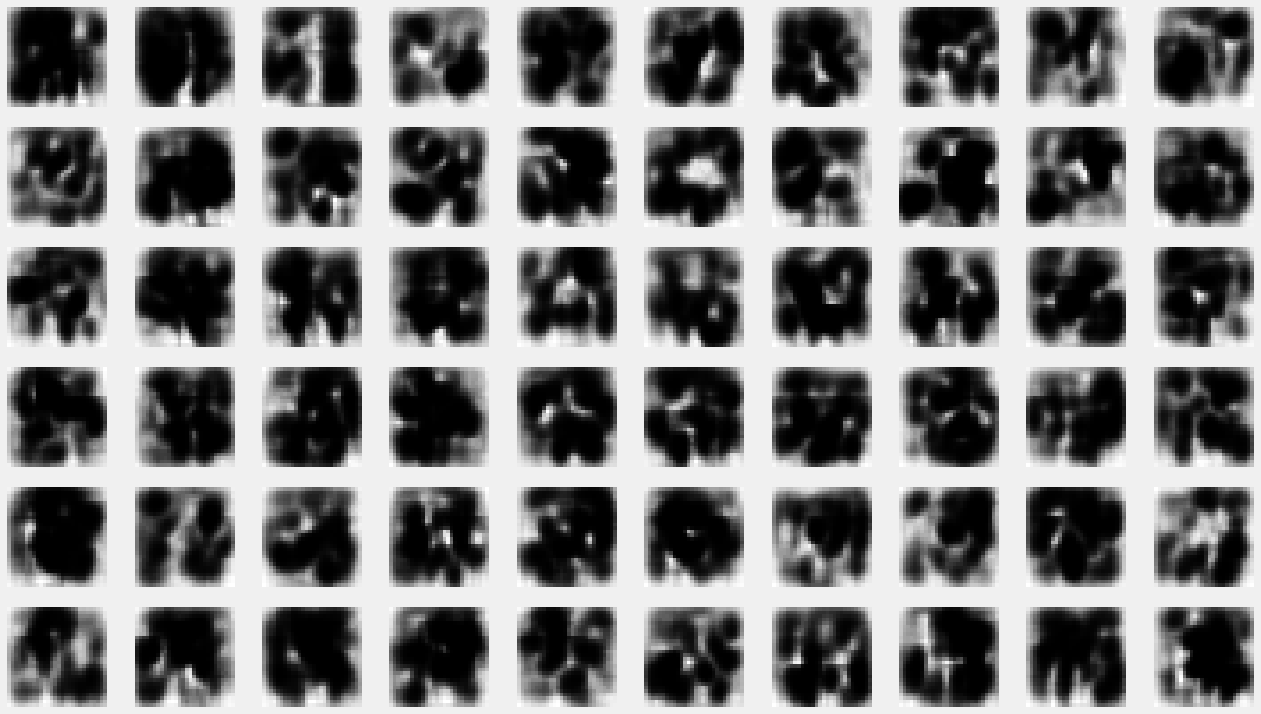

In [22]:
generated4cnn(model, 128)

## VAE

In [44]:
class VAECNN2(torch.nn.Module): 
    def __init__(self, latent_dim, beta=1.0):
        super().__init__()

         # YOUR CODE
        loss_function = torch.nn.MSELoss().to(device)
        kl_loss = torch.nn.KLDivLoss().to(device)
        self.d = latent_dim // 4

        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=64, out_channels=self.d, kernel_size=3, stride=2),
            torch.nn.Flatten(),
            
        )

        self.fc1 = torch.nn.Linear(self.d, 32)
        self.fc2 = torch.nn.Linear(self.d, 32)
        self.fc3 = torch.nn.Linear(32, self.d)
        
        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(in_channels=self.d, out_channels=64, kernel_size=3, stride=2),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=5, stride=1),
            torch.nn.Sigmoid(),
        )
        





    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size())
        z = mu + std * esp
        return z
    
        

        # YOUR CODE
        
   
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar     
  
    def forward(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        z = self.fc3(z)
        return self.decoder(z), mu, logvar
        
        
        # YOUR CODE
    
    def loss(self, img, rec):
        # YOUR CODE
        # Compute the total loss (per batch): Reconstruction Loss + KL Loss
        
        first_loss = loss_function(rec, img)
        second_loss = kl_loss(rec,img)
        return (first_loss + second_loss).sum(), first_loss, second_loss
        
        
        
        # YOUR CODE
    
    def reconstruct(self, x):
        return self.bottleneck(self.encoder(x))[0]


        
        
        # YOUR CODE


In [45]:
def train_eval_vae(epochs, lr, model, loader, testloader, decay_lr=0.9):
    pelosses = []
    pelosses_rec = []
    pelosses_kl = []
    pelosses_test = []
    pelosses_test_rec = []
    pelosses_test_kl = []

    model = model.to(device)
    loss_function = torch.nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr) #, weight_decay = 1e-8)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=decay_lr)
    
    for epoch in range(epochs):    
        peloss = 0.0
        peloss_rec = 0.0
        peloss_kl = 0.0
        for (image, _) in loader:
            image = image.to(device)
            reconstructed = model(image)  
            loss, recloss, klloss = model.loss(reconstructed, image)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()        
            peloss += loss.item()
            peloss_rec += recloss.item()
            peloss_kl += klloss.item()
        peloss /= len(loader)
        peloss_rec /= len(loader)
        peloss_kl /= len(loader)
        pelosses.append(peloss)
        pelosses_rec.append(peloss_rec)
        pelosses_kl.append(peloss_kl)
        
        scheduler.step()
    
        testpeloss = 0.0
        testpeloss_rec = 0.0
        testpeloss_kl = 0.0
        with torch.no_grad():
            for (image,_) in testloader:
                image = image.to(device)
                reconstructed = model(image)  
                loss, recloss, klloss = model.loss(reconstructed, image)
                testpeloss += loss.item()
                testpeloss_rec += recloss.item()
                testpeloss_kl += klloss.item()
            testpeloss /= len(testloader)
            testpeloss_rec /= len(testloader)
            testpeloss_kl /= len(testloader)
            pelosses_test.append(testpeloss)
            pelosses_test_rec.append(testpeloss_rec)
            pelosses_test_kl.append(testpeloss_kl)
        print("Epoch %i: %6.4f  %6.4f %6.4f %6.4f %6.4f %6.4f"%(epoch, peloss, peloss_rec, peloss_kl, testpeloss, testpeloss_rec, testpeloss_kl))
    return pelosses, pelosses_rec, pelosses_kl, pelosses_test, pelosses_test_rec, pelosses_test_kl

In [46]:
epochs = 3
lr = 0.001
vae = VAECNN2(128)
pelosses, pelosses_rec, pelosses_kl, pelosses_test, pelosses_test_rec, pelosses_test_kl \
                                        = train_eval_vae(epochs, lr, vae, loader, testloader,decay_lr=1.0)

RuntimeError: ignored

In [ ]:
plt.figure(figsize=(18,12))
plt.xlabel('Epochs')
plt.ylabel('Loss')
epochs = len(pelosses)
plt.plot(torch.arange(epochs)+1, pelosses, 'b-', label="train_loss")
plt.plot(torch.arange(epochs)+1, pelosses_test, 'r-',label="test_loss")    
plt.bar(torch.arange(epochs)+1, pelosses_test_rec, label="test_loss_rec")
plt.bar(torch.arange(epochs)+1, pelosses_test_kl, bottom=pelosses_test_rec, label="test_loss_kl")
plt.legend()

In [ ]:
def plot_samples_vae(dataset, model):
    n = 10
    m = 1
    model.to("cpu")
    indices = torch.randint(len(dataset), size=(n,))
    cols, rows = n, m+1
    figure = plt.figure(figsize=(18, (m+1)*2))
    for i in range(n):
        idx = indices[i].item()
        img, label = dataset[idx]
        figure.add_subplot(rows, cols, i+1)
        plot_img(img.numpy(), "")
    
        figure.add_subplot(rows, cols, n+i+1)
        img, label = dataset[idx]
        img = model.reconstruct(img).detach().numpy()
        plot_img(img, "")    
    plt.show()

In [ ]:
plot_samples_vae(testset, vae)

In [ ]:
def generated(model):
    cols = 10
    rows = 6
    model = model.to("cpu")
    plt.figure(figsize=(20, rows*2))
    ax = plt.subplot(rows, cols, 1)
    for j in range(rows):
        for i in range(cols):
            z = torch.randn((model.d,)).view(-1,model.d,1,1)
            rec = model.decoder(z).detach().numpy()        
            ax = plt.subplot(rows, cols, j*cols+i+1)
            plot_img(rec.reshape(28,28), "")
        
    plt.show()

In [ ]:
generated(vae)